# 基本设置

In [8]:
from toolkits.setup import specific_func
specific_func.set_ch_pd()
from toolkits.setup.date_time import get_day_list
from toolkits.nlp import pre_cor_circ
from toolkits.nlp import pre_cor_cbrc
from toolkits.nlp import myclass_circ
from toolkits.nlp import myclass_cbrc

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.813 seconds.
Prefix dict has been built succesfully.


In [12]:
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier
from jieba import analyse
import jieba

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [28]:
from gensim.models import Word2Vec
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler

# load model

In [2]:
model_path = 'model/cbirc_skip_gram.model' # 输出模型
vector_path = 'model/cbirc_skip_gram.vector' # 原始c版本word2vec的vector格式的模型
model = Word2Vec.load(model_path)

## train_test data

In [9]:
filepath_raw = 'datasets_raw/train_test/'
filename_list = os.listdir(filepath_raw)
# filename_list = filename_list[:1]
print('文件数：', len(filename_list))

file_num = 0
with open('datasets_pre/label_content.txt', 'w') as f:
    for index, filename in enumerate(filename_list):
        tmp_data = pd.read_excel(filepath_raw + filename)
        print('filename: ', index +1, filename, tmp_data.shape)
        file_num += tmp_data.shape[0]
        for index in tmp_data.index:
            content = str(tmp_data.loc[index, 'title']) + "。" + str(tmp_data.loc[index, 'content'])
            label = str(tmp_data.loc[index, 'label'])
            string_pre = pre_cor_circ.handle_contents([content])
            f.write(label + '&' + string_pre[0] + '\n')

del tmp_data
print('file_num: ', file_num)

文件数： 1
filename:  1 title_content_label.xlsx (6545, 4)
file_num:  6545


In [20]:
content = []
label = []
with open('datasets_pre/label_content.txt', 'r') as f:
    for line in f.readlines():
        label_content = line.strip().split("&")
        label.append(label_content[0])
        content.append(label_content[1].split())       
print('content_num：', len(content))
print('label_num：', len(label))

content_num： 6545
label_num： 6545


In [22]:
X_train, X_test, y_train, y_test = train_test_split(content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 4581
训练集-各类数量： Counter({'-1': 2358, '0': 2223})
测试集： 1964
测试集-各类数量： Counter({'-1': 1021, '0': 943})



# 由单词到段落，尝试1：向量平均

电影评论数据集处理起来一个比较麻烦的地方在于，评论的长度是不一样的。我们需要提取出每一个词的向量，然后把它们转换为一个特征集，而且每个评论的特征长度是一样的。

因为每一个单词有一个300维的特征，我们可以用特征操作来把一个评论中的单词合并起来。一个简单的方法就是对所有的词向量取平均。（如果取平均的话，我们需要移除stop words，因为会带来噪音）

下面是计算特征向量平均值的代码：

In [16]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    
    nwords = 0
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    
    # Initialize a counter
    counter = 0
    
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    
    # Loop through the reviews
    for review in reviews:
       
        # Print a status message every 1000th review
        if counter%1000 == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
       
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

接下来我们调用上面的函数来给每一个评论创建一个平均向量。下面会运行几分钟：

In [17]:
# Set values for various parameters
num_features = 400    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
# context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [24]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word removal.

trainDataVecs = getAvgFeatureVecs(X_train, model, num_features )

print("Creating average feature vecs for test reviews")

testDataVecs = getAvgFeatureVecs(X_test, model, num_features )

Review 0 of 4581
Review 1000 of 4581
Review 2000 of 4581
Review 3000 of 4581
Review 4000 of 4581
Creating average feature vecs for test reviews
Review 0 of 1964
Review 1000 of 1964


## tarin test

数据处理结束，我们得到了每个评论的平均向量，我们用这个特征向量来训练一个随机森林模型。

In [33]:
clf = XGBClassifier(max_depth=7,objective='binary:logistic')
clf.fit(trainDataVecs, y_train)
# print(clf.score(X_train, y_train))
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
y_pred_class = forest.predict( testDataVecs )
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
print('AUC: ', metrics.auc(fpr, tpr))
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9058044806517311
              precision    recall  f1-score   support

          -1       0.93      0.89      0.91      1021
           0       0.89      0.92      0.90       943

   micro avg       0.91      0.91      0.91      1964
   macro avg       0.91      0.91      0.91      1964
weighted avg       0.91      0.91      0.91      1964

confusion_matrix: 
[[908 113]
 [ 72 871]]


In [36]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100 )
forest = forest.fit(trainDataVecs, y_train)

y_pred_class = forest.predict( testDataVecs )
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
print('AUC: ', metrics.auc(fpr, tpr))
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9068228105906314
              precision    recall  f1-score   support

          -1       0.93      0.89      0.91      1021
           0       0.89      0.92      0.90       943

   micro avg       0.91      0.91      0.91      1964
   macro avg       0.91      0.91      0.91      1964
weighted avg       0.91      0.91      0.91      1964

confusion_matrix: 
[[911 110]
 [ 73 870]]


## 参数调优

In [76]:
from sklearn.model_selection import GridSearchCV

In [ ]:
scoring = {'AUC': 'roc_auc', 'Accuracy': metrics.make_scorer(metrics.accuracy_score)}
param_grid = dict(n_estimators = range(100,271,30), # 迭代次数/分类器个数
                  learning_rate=[0.01, 0.1, 0.3], 
                  max_depth=range(3,14,2), # 决策树最大深度
                  min_child_weight=[4, 5, 6]) 
print(param_grid)

xgb = XGBClassifier(objective='binary:logistic')
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
clf_gs = GridSearchCV(xgb, param_grid, cv = 5, scoring = scoring, refit='AUC', 
                   n_jobs = 10, verbose = 10, return_train_score=True)
clf_gs.fit(content_vecs, labels)
results = clf_gs.cv_results_

{'n_estimators': range(100, 271, 30), 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': range(3, 14, 2), 'min_child_weight': [4, 5, 6]}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   18.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   43.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  3.7min


In [110]:
col_list = ['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_n_estimators', 
            'mean_test_AUC', 'std_test_AUC', 'mean_train_AUC', 'std_train_AUC', 
            'mean_test_Accuracy', 'std_test_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy']
data_list = []

for col in col_list:
    data_list.append(results[col].data.tolist())
result_plot = pd.DataFrame(data_list).T
result_plot.columns = col_list
result_plot['param_max_depth'] = result_plot['param_max_depth'].astype(int)
result_plot['param_min_child_weight'] = result_plot['param_min_child_weight'].astype(int)
result_plot['param_n_estimators'] = result_plot['param_n_estimators'].astype(int)
result_plot_data = result_plot.set_index(['param_learning_rate', 'param_n_estimators', 'param_max_depth', 'param_min_child_weight'])
result_plot_data.head()

mean_test_AUC  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                  
0.010               100                3               4                               0.911   
                    130                3               4                               0.916   
                    160                3               4                               0.920   
                    190                3               4                               0.923   
                    220                3               4                               0.925   

                                                                               std_test_AUC  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                 
0.010               100                3               4                              0.071   
                    130                3               4                              0.069   
                    160                3               4                              0.066   
                    190                3               4                              0.065   
                    220                3               4                              0.063   

                                                                               mean_train_AUC  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                   
0.010               100                3               4                                0.948   
                    130                3               4                                0.954   
                    160                3               4                                0.958   
                    190                3               4                                0.961   
                    220                3               4                                0.964   

                                                                               std_train_AUC  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                  
0.010               100                3               4                               0.009   
                    130                3               4                               0.009   
                    160                3               4                               0.008   
                    190                3               4                               0.007   
                    220                3               4                               0.007   

                                                                               mean_test_Accuracy  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                       
0.010               100                3               4                                    0.839   
                    130                3               4                                    0.843   
                    160                3               4                                    0.848   
                    190                3               4                                    0.853   
                    220                3               4                                    0.857   

                                                                               std_test_Accuracy  \
param_learning_rate param_n_estimators param_max_depth param_min_child_weight                      
0.010               100                3               4                                   0.073   
                    130                3               4                                   0.077   
                    160                3               4                                   0.073   
                    190                3               4                                   0.072   
                    220                3               4                       

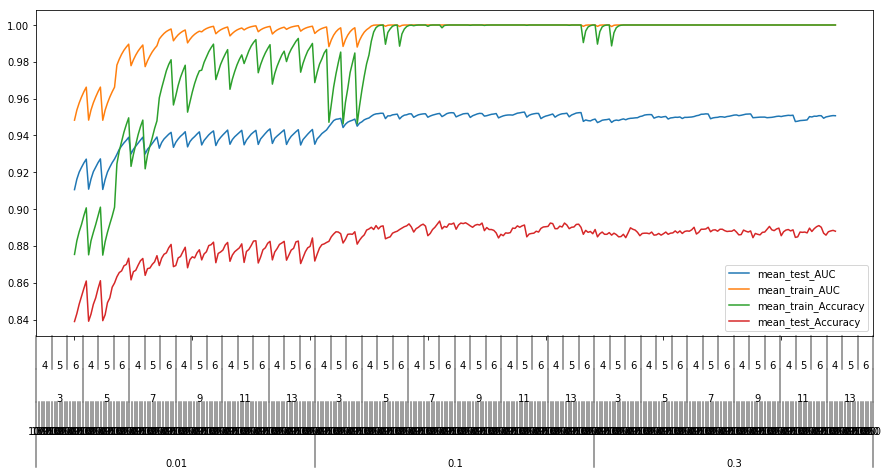

In [111]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

ax = result_plot_data[['mean_test_AUC', 'mean_train_AUC',
             'mean_train_Accuracy', 'mean_test_Accuracy']].plot(kind='line',stacked=False, figsize = (15, 6))
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, result_plot_data[['mean_test_AUC', 'mean_train_AUC',
             'mean_train_Accuracy', 'mean_test_Accuracy']])

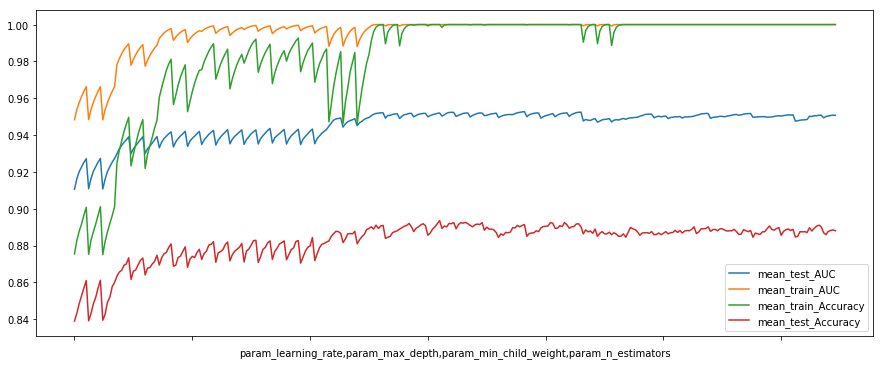

In [103]:
result_plot[['mean_test_AUC', 'mean_train_AUC',
             'mean_train_Accuracy', 'mean_test_Accuracy']].plot(figsize = (15, 6))

In [81]:
# clf.grid_scores_, 
clf_gs.best_params_, clf_gs.best_score_

({'learning_rate': 0.1,
  'max_depth': 11,
  'min_child_weight': 5,
  'n_estimators': 250},
 0.9527012745605056)

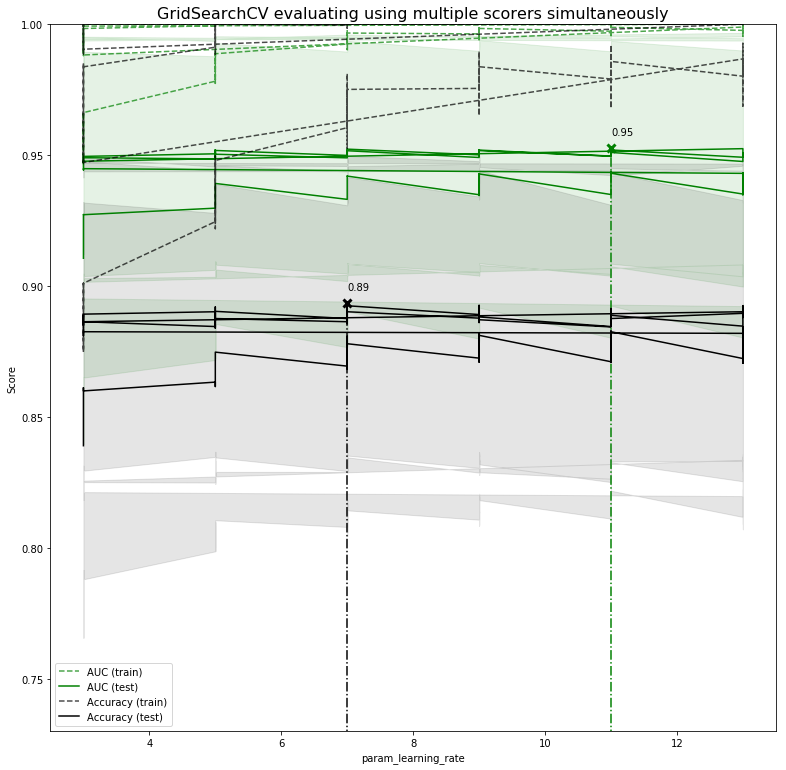

In [72]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("param_learning_rate")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(result_plot['param_max_depth'], dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

## Learning Curves

In [37]:
from toolkits.ml import fig_scikit_index 
from sklearn.model_selection import ShuffleSplit

In [43]:
content_vecs = getAvgFeatureVecs(content, model, num_features )
content_vecs = np.array(content_vecs)
labels = np.array(label)

print('content_vecs: ', content_vecs.shape)
print('labels: ', labels.shape)

Review 0 of 6545
Review 1000 of 6545
Review 2000 of 6545
Review 3000 of 6545
Review 4000 of 6545
Review 5000 of 6545
Review 6000 of 6545
content_vecs:  (6545, 400)
labels:  (6545,)


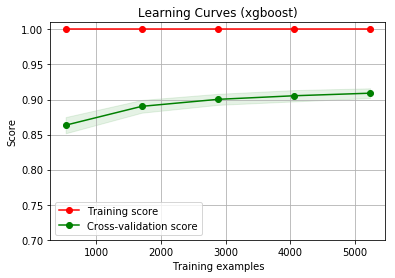

In [71]:
title = "Learning Curves (xgboost)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
clf = XGBClassifier(max_depth=11,objective='binary:logistic', 
                    learning_rate = 0.1, min_child_weight = 5,
                    n_estimators = 250)
fig_scikit_index.plot_learning_curve(clf, title, content_vecs, labels, ylim=(0.7, 1.01), cv=cv, n_jobs=8)
plt.show()

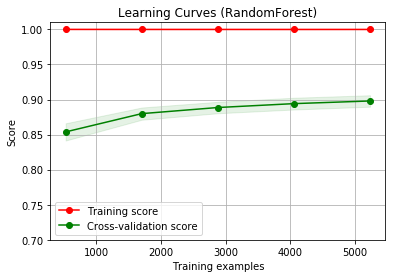

In [54]:
title = "Learning Curves (RandomForest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
clf = RandomForestClassifier(n_estimators = 50 )
fig_scikit_index.plot_learning_curve(clf, title, content_vecs, labels, ylim=(0.7, 1.01), cv=cv, n_jobs=8)
plt.show()

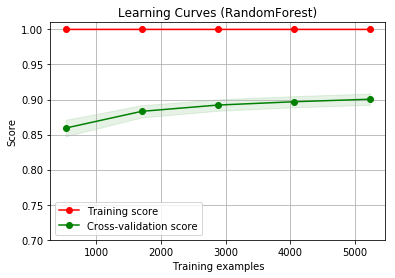

In [46]:
title = "Learning Curves (RandomForest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
clf = RandomForestClassifier(n_estimators = 100 )
fig_scikit_index.plot_learning_curve(clf, title, content_vecs, labels, ylim=(0.7, 1.01), cv=cv, n_jobs=8)
plt.show()

#  由单词到段落，尝试2：聚类

word2vec会给词义上相近的单词进行聚类，所以另一个可行的方法是利用一个类中单词的相似性。这种对单词分组的方法叫做向量量化。第一步要做的，就是找到词聚类的中心，可以通过聚类算法来做的，比如K-Means。

在K-Means中，对于一个段落，需要设置一个K，或聚类的数量。如何决定创建多少个聚类？反复试验的结果表示，数量较少的类，比如一个类里有5个词，会有更好的效果。我们使用[scikit-learn来实现kmeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

如果K很大的话，会非常慢；原文大概运行了40min。这里我们设置一个计时器来查看花了多长时间

In [50]:
num_clusters
kmeans_clustering

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14170, n_init=10, n_jobs=8, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, 
# or an average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = word_vectors.shape[0] // 10

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters, n_jobs=4 , verbose=10)

In [53]:
kmeans_clustering.fit(word_vectors)

joblib.dump(kmeans_clustering, "model/kmeans_clustering.model")

Initialization complete
start iteration
done sorting
end inner loop


MemoryError: 

In [ ]:
kmeans_clustering = joblib.load( "model/kmeans_clustering.model")
idx = kmeans_clustering.predict( word_vectors )

idx.shape

idx: Index of the cluster each sample belongs to.

现在每一个单词的聚合赋值存储在了idx里，原始Word2vec模型里的词汇表，保存在model.wv.index2word。为了方便，我们用把这些集合在一个字典里：

In [ ]:
# Create a Word / Index dictionary, 
# mapping each vocabulary word to a cluster number 
word_centroid_map = dict(zip( model.wv.index2word, idx ))

word_centroid_map包含的是每个单词所属于的类

上面有些抽象，现在我们看一下每个类里有什么。我们打印出类0~类9：

In [ ]:
# For the first 10 clusters
for cluster in range(0, 10):

    # Print the cluster number  
    print("\nCluster %d" % cluster)

    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0, len(word_centroid_map.values())):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)

我们可以看到这些类的质量差别很大。cluster 1基本包含的是名字，有类里的词之间是有关系的，但是有些类的词之间就没什么关系。

不管怎么说，现在每个单词都有了一个类，我们可以写一个函数，把评论转化为重心袋(convert reviews into bags-of-centroids)。其实就像词袋一样，但是这种方法是用语义上相关的类，而不是单独的单词：

In [ ]:
def create_bag_of_centroids( wordlist, word_centroid_map ):

    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1

    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )

    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1

    # Return the "bag of centroids"
    return bag_of_centroids

上面的函数会对每一个评论返还一个numpy数组，这个数组代表特征，特征的数量和聚类的数量一样。`max(word_centroid_map.values())`得到的结果是3297，所以一共是3298个类。

然后我们给训练集和测试集构建bags of centroids。然后训练随机森林并检验结果：

In [ ]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros(( test["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map )
    counter += 1

In [ ]:
# Fit a random forest and extract predictions 
forest = RandomForestClassifier(n_estimators = 100)

# Fitting the forest may take a few minutes
print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,train["sentiment"])
result = forest.predict(test_centroids)

# Write the test results 
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "result/BagOfCentroids.csv", index=False, quoting=3 )